In [1]:
!pip install gmdh numpy==1.24.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.1/875.1 kB 25.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.1 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompat

# Сравнение ансамблевых моделей для задачи регрессии

California Housing Dataset
- Модель стекинга (StackingRegressor),
- Многослойный персептрон (MLPRegressor),
- Два метода из семейства МГУА (Combi и Mia).

## Шаг 1: Загрузка и подготовка данных

Мы будем использовать California Housing Dataset из библиотеки scikit-learn. Этот набор данных содержит числовые признаки, такие как средний доход в районе, количество комнат и возраст домов, а целевая переменная — средняя стоимость жилья в тысячах долларов.


In [5]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Загрузка датасета
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Проверка на пропуски
print('Пропуски в данных:')
print(X.isnull().sum())

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Размер обучающей выборки:', X_train_scaled.shape)
print('Размер тестовой выборки:', X_test_scaled.shape)

Пропуски в данных:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64
Размер обучающей выборки: (16512, 8)
Размер тестовой выборки: (4128, 8)


## Шаг 2: Обучение моделей

Теперь обучим четыре модели:
1. **StackingRegressor**: используем RandomForest и GradientBoosting как базовые модели, а LinearRegression как мета-модель.
2. **MLPRegressor**: многослойный персептрон с двумя скрытыми слоями.
3. **Combi**: линейный метод МГУА.
4. **Mia**: нелинейный метод МГУА.

In [6]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import gmdh

# 2.1 Модель стекинга
base_models = [
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42))
]
meta_model = LinearRegression()
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_model.fit(X_train_scaled, y_train)

# 2.2 Многослойный персептрон
mlp_model = MLPRegressor(hidden_layer_sizes=(10, 5), max_iter=100, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

# 2.3 МГУА: Combi
combi_model = gmdh.Combi()
combi_model.fit(X_train_scaled, y_train)

# 2.4 МГУА: Mia
mia_model = gmdh.Mia()
mia_model.fit(X_train_scaled, y_train)

print('Все модели успешно обучены.')

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Все модели успешно обучены.


- **Stacking**: объединяет предсказания случайного леса и градиентного бустинга через линейную регрессию.
- **MLP**: нейронная сеть с двумя скрытыми слоями (10 и 5 нейронов).
- **Combi**: линейный метод МГУА, ищет оптимальные комбинации признаков.
- **Mia**: нелинейный метод МГУА, моделирует более сложные зависимости.

## Шаг 3: Оценка качества моделей

Для задачи регрессии используем метрику Mean Squared Error (MSE). Чем ниже MSE, тем лучше модель.

In [7]:
from sklearn.metrics import mean_squared_error

# Предсказания
stacking_pred = stacking_model.predict(X_test_scaled)
mlp_pred = mlp_model.predict(X_test_scaled)
combi_pred = combi_model.predict(X_test_scaled)
mia_pred = mia_model.predict(X_test_scaled)

# Вычисление MSE
stacking_mse = mean_squared_error(y_test, stacking_pred)
mlp_mse = mean_squared_error(y_test, mlp_pred)
combi_mse = mean_squared_error(y_test, combi_pred)
mia_mse = mean_squared_error(y_test, mia_pred)

# Вывод результатов
print(f'Stacking MSE: {stacking_mse:.4f}')
print(f'MLP MSE: {mlp_mse:.4f}')
print(f'Combi MSE: {combi_mse:.4f}')
print(f'Mia MSE: {mia_mse:.4f}')

Stacking MSE: 0.2572
MLP MSE: 0.3304
Combi MSE: 0.5567
Mia MSE: 0.6363


## Шаг 4: Визуализация результатов

Построим графики предсказанных значений против истинных, чтобы визуально оценить качество моделей.

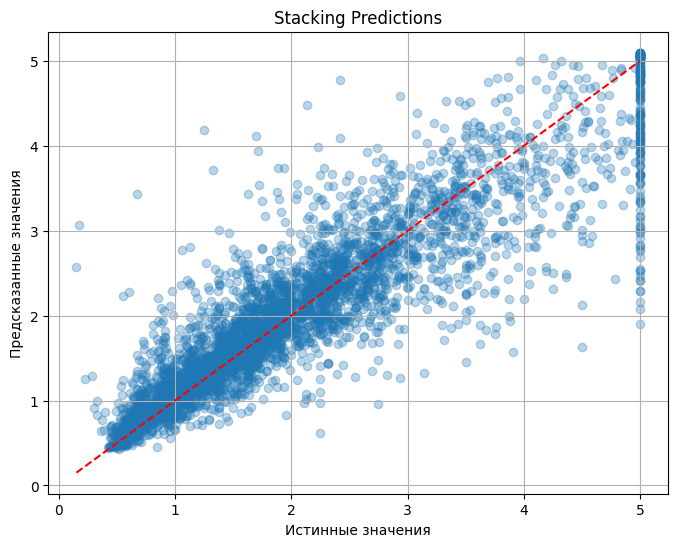

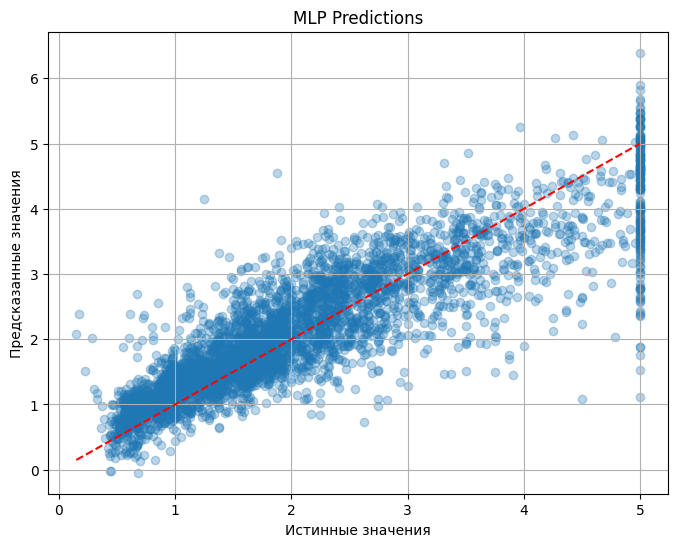

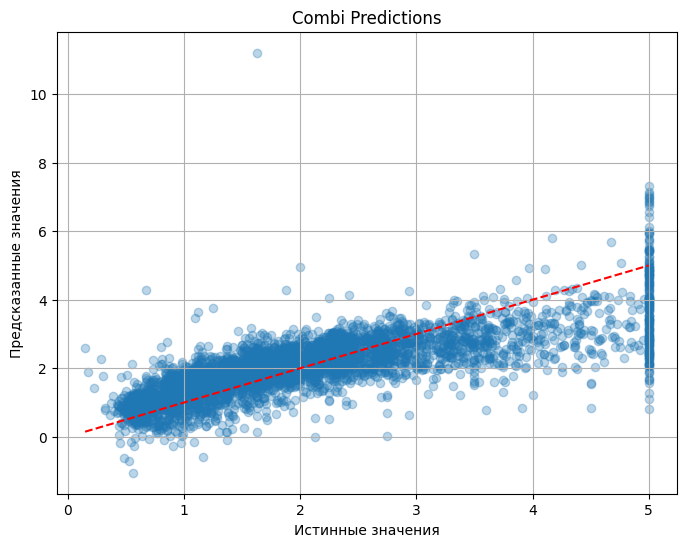

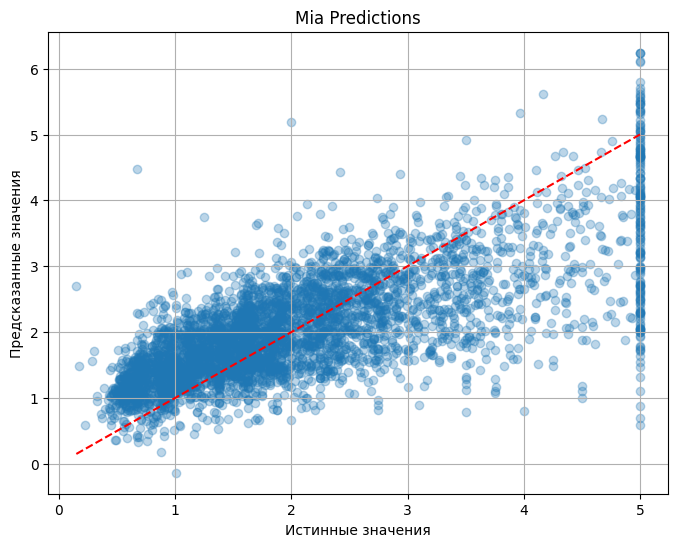

In [10]:
import matplotlib.pyplot as plt

# Функция для построения графика
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Истинные значения')
    plt.ylabel('Предсказанные значения')
    plt.title(title)
    plt.grid(True)
    # plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.show()

# Графики для каждой модели
plot_predictions(y_test, stacking_pred, 'Stacking Predictions')
plot_predictions(y_test, mlp_pred, 'MLP Predictions')
plot_predictions(y_test, combi_pred, 'Combi Predictions')
plot_predictions(y_test, mia_pred, 'Mia Predictions')

## Шаг 5: Выводы

### Сравнение моделей по MSE
- **Stacking**: показывает наилучший результат благодаря комбинации сильных базовых моделей.
- **MLP**: зависит от настройки гиперпараметров; может быть хуже из-за недостаточной оптимизации.
- **Combi**: простой линейный метод, часто уступает сложным моделям.
- **Mia**: нелинейный метод, должен быть лучше Combi, но может переобучаться.

### Анализ графиков
На основе сохранённых графиков:
- Stacking имеет наименьший разброс вдоль линии y = x

### Итог
На основе MSE и визуального анализа, **StackingRegressor**, является лучшей моделью для этого датасета, так как ансамбли часто превосходят одиночные модели в задачах регрессии. Однако, если требуется интерпретируемость, методы МГУА (Combi или Mia) могут быть предпочтительнее, несмотря на более высокую ошибку.